In [1047]:
# Insira sua resposta aqui
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
sns.set()
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn import linear_model
import sklearn.metrics as metrics
from scipy.stats import zscore
from sklearn.svm import SVR, LinearSVR,NuSVR
from sklearn.naive_bayes import GaussianNB
sns.set()

In [1048]:
comp_price = pd.read_csv('test_prc/comp_prices.csv', sep=',')
sales = pd.read_csv('test_prc/sales.csv', sep=',')

# B2W Challange

The sales.csv file contains transactional information where each line represents a sale. The comp_prices.csv file contains monitoring data of competitors’ prices. We have data available for 6 competitors, C1 to C6, which are monitored twice per day. The information below describes the data in each column:

- **PROD_ID**: Product ID. We provide data for 9 different products, P1 to P9;
- **DATE_ORDER**: Sales Date, under YYYY-MM-DD format;
- **QTY_ORDER**: Quantity Sold;
- **REVENUE**: Sale revenue. There can be variations of the price for the same product, depending on the sales channel or discounts, which are applied to the base price;
- **DATE_EXTRACTION**: Date and Time of the extraction of the competitors’ price, under YYYY-MM-DD HH:MM:SS format;
- **COMPETITOR**: Competitors’ ID (C1 to C6);
- **COMPETITOR_PRICE**: Competitors’ price per product, which can depend on the payment method;
- **PAY_TYPE**: Payment Method (1=deferred payment, 2=immediate payment).

1) Models for Demand Forecasting: The main objective is to create a model to predict the quantity sold for each product given a prescribed price. Along with the statistical model, we need metrics, relationships and descriptions of these data in order to understand the sales behavior. What does the data tell us? How are the different data sources related? Is there a particular competitor that seems more important?

2) Presentation of the results: we want to know what were the steps and your strategy (approach to the problem) during the analysis, even if these may seem wrong. The process you went through and the reasoning behind it, is as important as the solutions you found. For this, please prepare a clear and objective presentation to explain both your methodology and your results. In case you are selected for the interview, you will need to make a 20-minute (max) presentation.

In [1049]:
sales['DATE_ORDER'] = pd.to_datetime(sales['DATE_ORDER'])
comp_price['DATE_EXTRACTION_DAY'] = pd.to_datetime(comp_price['DATE_EXTRACTION'].str.split(' ').str[0]) #compare extration by day
comp_price['DATE_EXTRACTION'] = pd.to_datetime(comp_price['DATE_EXTRACTION'])

# Data Preparation / Exploratory Analysis

Given the objective of the prescribed problem (quantity sold of each product given a price) it is understood that the COMPETITOR_PRICE metric is of great relevance for the forecast and it will be used as a feature of the model. For this, it will be necessary to create a list of data by day and product.

In [1050]:
sales_agg = sales.groupby(['PROD_ID','DATE_ORDER']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['min']}).reset_index()
sales_agg.columns = sales_agg.columns.get_level_values(0)

In [1051]:
comp_dummies = pd.get_dummies(data=comp_price, columns=['COMPETITOR', 'PAY_TYPE'])

columns = ['PROD_ID',
            'DATE_EXTRACTION_DAY', 
            'COMPETITOR_C1', 
            'COMPETITOR_C2', 
            'COMPETITOR_C3', 
            'COMPETITOR_C4', 
            'COMPETITOR_C5', 
            'COMPETITOR_C6', 
            'PAY_TYPE_1', 
            'PAY_TYPE_2']

comp_price_agg = comp_dummies.groupby(columns).agg({'COMPETITOR_PRICE': ['min']}).reset_index()
comp_price_agg.columns = comp_price_agg.columns.get_level_values(0)

In [1052]:
comp_price_agg_min_f = comp_price_agg.groupby(['PROD_ID','DATE_EXTRACTION_DAY']).agg({'COMPETITOR_PRICE': 'last'}).reset_index()

In [1053]:
df = pd.DataFrame.merge(sales_agg, comp_price_agg_min_f, how='left', left_on=['PROD_ID','DATE_ORDER'], right_on = ['PROD_ID','DATE_EXTRACTION_DAY']).drop(['DATE_EXTRACTION_DAY'], axis=1)

The relationship between our effective sale (REVENUE) and the competitors' price (COMPETITOR_PRICE) was created. Data were related by day and product where competitor data collection was reduced to the lowest price of the day per competitor.

In [1054]:
df

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE,COMPETITOR_PRICE
0,P1,2015-02-04,10.0,1499.00,NaN
1,P1,2015-02-05,12.0,1349.10,NaN
2,P1,2015-02-06,21.0,1349.10,NaN
3,P1,2015-02-07,4.0,1499.00,NaN
4,P1,2015-02-08,7.0,1499.00,NaN
...,...,...,...,...,...
2157,P9,2015-10-10,129.0,388.89,395.82
2158,P9,2015-10-11,87.0,388.66,395.82
2159,P9,2015-10-12,110.0,388.63,395.76
2160,P9,2015-10-13,328.0,341.10,393.00


## Outlier handling

Outliers were filtered based on a standard deviation above 3 in their product dataset. These values (REVENUE) have been replaced by your average.
For COMPETITOR_PRICE the outliers were replaced by the same corresponding REVENUE value.

In [1055]:
base = 'PROD_ID'

for b in df[base].unique():
    n = df["REVENUE"].loc[df[base] == b]
    n,m = n[np.abs(zscore(n)) > 2].index, 'REVENUE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].loc[df[base] == b].mean()

    n = df["QTY_ORDER"].loc[df[base] == b]
    n,m = n[np.abs(zscore(n)) > 2].index, 'QTY_ORDER'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['QTY_ORDER'].loc[df[base] == b].mean()
    
    n,m = df['COMPETITOR_PRICE'].loc[(np.isnan(df['COMPETITOR_PRICE'])) & (df[base] == b)].index, 'COMPETITOR_PRICE'
    if len(n):
        for i in n:
            df.at[int(i),m] = df['REVENUE'].iloc[int(i)]

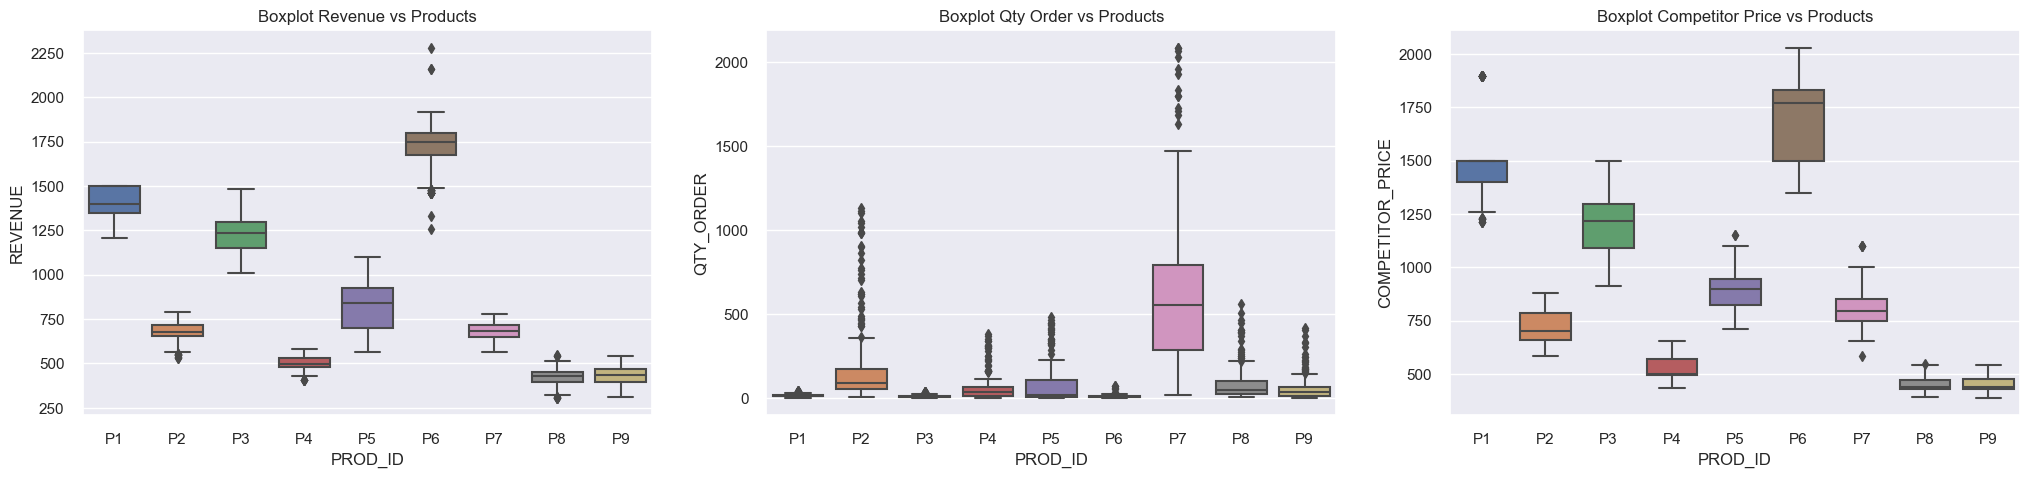

In [1056]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

sns.boxplot(data=df, x='PROD_ID', y='REVENUE', ax=ax[0])
ax[0].set_title("Boxplot Revenue vs Products")
sns.boxplot(data=df, x='PROD_ID', y='QTY_ORDER', ax=ax[1])
ax[1].set_title("Boxplot Qty Order vs Products")
sns.boxplot(data=df, x='PROD_ID', y='COMPETITOR_PRICE', ax=ax[2])
ax[2].set_title("Boxplot Competitor Price vs Products")
plt.show()

## Transform to supervised

I decided to opt for the use of supervised models to solve the problem in order to obtain more possibilities for parameterization and model diversity. For that, I made the transformation of the problem in a supervised environment.

I used Pandas' shift() function to automatically create new frames of time series problems given the desired length of the input and output sequences. This is a useful tool as it will allow me to explore different framings of a time series problem with machine learning algorithms to see what could result in better performing models.

In [1057]:
def transform_to_supervised(df,
                            previous_steps=1, 
                            forecast_steps=1,
                            dropnan=True):
    
    # original column names
    col_names = df.columns
    print(col_names)
    
    # list of columns and corresponding names we'll build from 
    # the originals found in the input DataFrame
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(previous_steps, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_name, i)) for col_name in col_names]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, forecast_steps):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % col_name) for col_name in col_names]
        else:
            names += [('%s(t+%d)' % (col_name, i)) for col_name in col_names]

    # put all the columns together into a single aggregated DataFrame
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [1058]:
base = 'PROD_ID'
columns = ['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE']
df_transformed = pd.DataFrame()

for b in df[base].unique():

    dft = transform_to_supervised(df[columns].loc[df[base] == b], previous_steps=2, forecast_steps=3)
    dft[base] = b
    df_transformed = df_transformed.append(dft, ignore_index=True,sort=False)

df_transformed

Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')
Index(['QTY_ORDER', 'REVENUE', 'COMPETITOR_PRICE'], dtype='object')


,QTY_ORDER(t-2),REVENUE(t-2),COMPETITOR_PRICE(t-2),QTY_ORDER(t-1),REVENUE(t-1),COMPETITOR_PRICE(t-1),QTY_ORDER(t),REVENUE(t),COMPETITOR_PRICE(t),QTY_ORDER(t+1),REVENUE(t+1),COMPETITOR_PRICE(t+1),QTY_ORDER(t+2),REVENUE(t+2),COMPETITOR_PRICE(t+2),PROD_ID
0,10.0,1499.00,1499.00,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.000000,1499.00,1499.00,P1
1,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.000000,1424.05,1424.05,P1
2,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.000000,1349.10,1349.10,P1
3,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.000000,1259.10,1259.10,P1
4,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,16.000000,1259.10,1259.10,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,50.0,359.10,414.00,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.000000,388.89,395.82,P9
2122,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.000000,388.66,395.82,P9
2123,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.000000,388.63,395.76,P9
2124,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,328.000000,341.10,393.00,P9


After some necessary manipulations were made, features t-2, t-1, t+1 and t+2 were then created for Competitor Price and Qty Order in order to take them as model metrics and also eliminating the need for time of my model.

Some exploratory data analyzes were performed in order to extract possible useful information for the creation of the model.

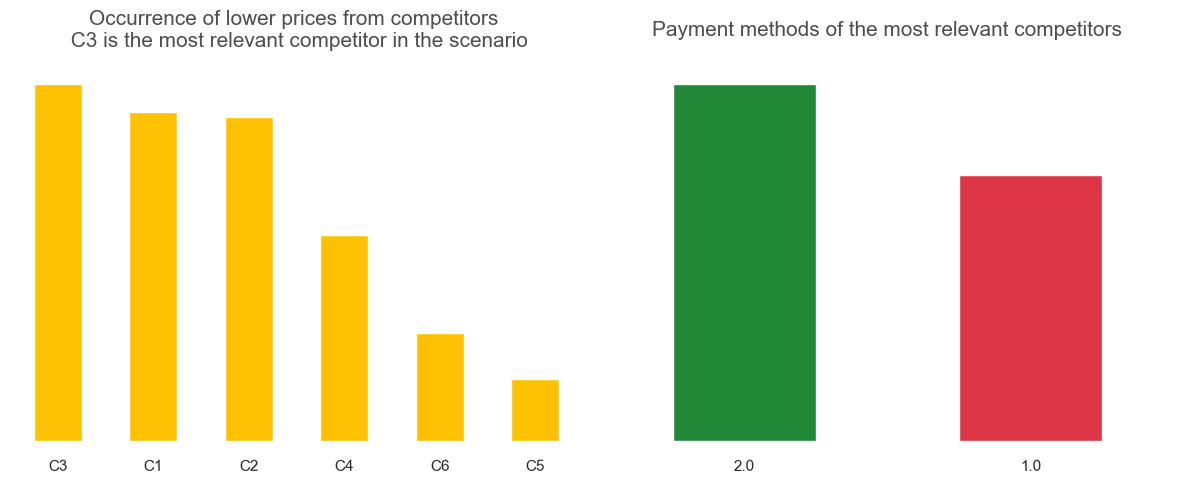

In [1059]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

comp_price_agg2 = comp_price.groupby(['PROD_ID', 'DATE_EXTRACTION_DAY', 'PAY_TYPE', 'COMPETITOR']).agg({'COMPETITOR_PRICE': ['min']}).reset_index()
comp_price_agg2.columns = comp_price_agg2.columns.get_level_values(0)
competitor_compare = pd.DataFrame.merge(sales_agg, comp_price_agg2, 
                                how='left', 
                                left_on=['PROD_ID','DATE_ORDER'], 
                                right_on = ['PROD_ID','DATE_EXTRACTION_DAY']).drop(['DATE_EXTRACTION_DAY'], axis=1,)
competitor_compare['COMPETITOR'].loc[competitor_compare['REVENUE'] > competitor_compare['COMPETITOR_PRICE']].value_counts(sort=True).plot.bar(rot=1, ax=ax[0], color='#ffc103')
competitor_compare['PAY_TYPE'].loc[competitor_compare['REVENUE'] > competitor_compare['COMPETITOR_PRICE']].value_counts(sort=True).plot.bar(rot=1, ax=ax[1], color=['#218838','#dc3545' ])

ax[0].get_yaxis().set_ticks([])
ax[0].grid(False)
ax[0].set(frame_on=False) 
ax[0].set_title("Occurrence of lower prices from competitors \n C3 is the most relevant competitor in the scenario", fontsize=15, color='#4f4e4e', y=1.03)
# ax[0].bar_label(ax[0].containers[0], padding=2, fontsize=12, color='#4f4e4e')

ax[1].get_yaxis().set_ticks([])
ax[1].grid(False)
ax[1].set(frame_on=False) 
ax[1].set_title("Payment methods of the most relevant competitors", fontsize=15, color='#4f4e4e', y=1.06)
# ax[1].bar_label(ax[1].containers[0], padding=2, fontsize=12, color='#4f4e4e')

fig.tight_layout()
plt.show()

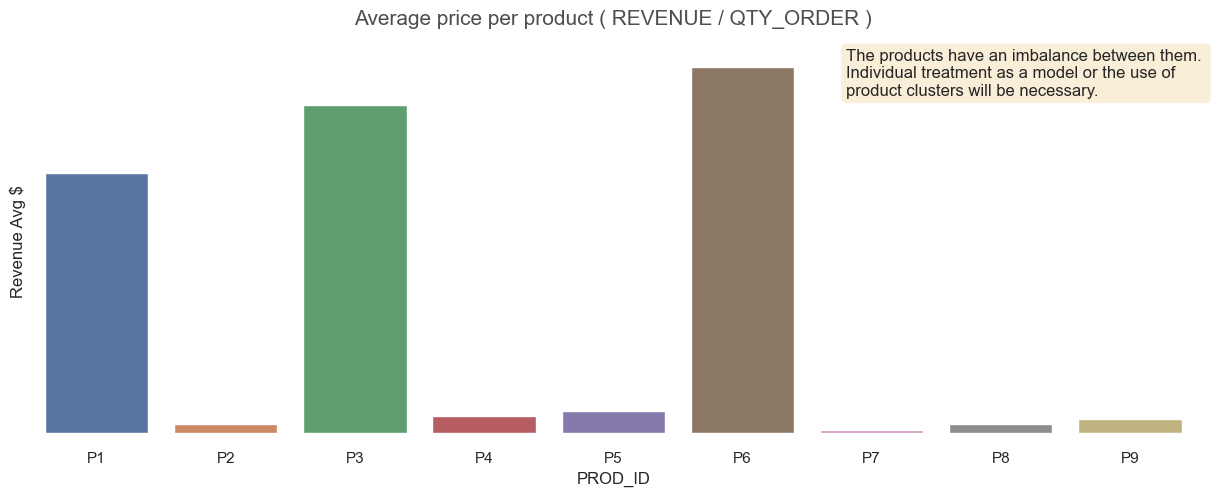

In [1060]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

sales_agg2 = sales_agg.groupby(['PROD_ID']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['sum']}).reset_index()
sales_agg2.columns = sales_agg2.columns.get_level_values(0)
sales_agg2['Revenue Avg $'] = sales_agg2['REVENUE'] / sales_agg2['QTY_ORDER'] 
# sales_agg2
# sales_agg2['Revenue Avg $'].plot.bar()
# plt.show()
sns.barplot(data=sales_agg2, y='Revenue Avg $', x='PROD_ID', ax=ax)

ax.get_yaxis().set_ticks([])
ax.grid(False)
ax.set(frame_on=False) 
ax.set_title("Average price per product ( REVENUE / QTY_ORDER )", fontsize=15, color='#4f4e4e', y=1.04)
# ax.bar_label(ax.containers[0], padding=2, fontsize=12, color='#4f4e4e')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.7, 1, 'The products have an imbalance between them. \nIndividual treatment as a model or the use of\nproduct clusters will be necessary.', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.show()

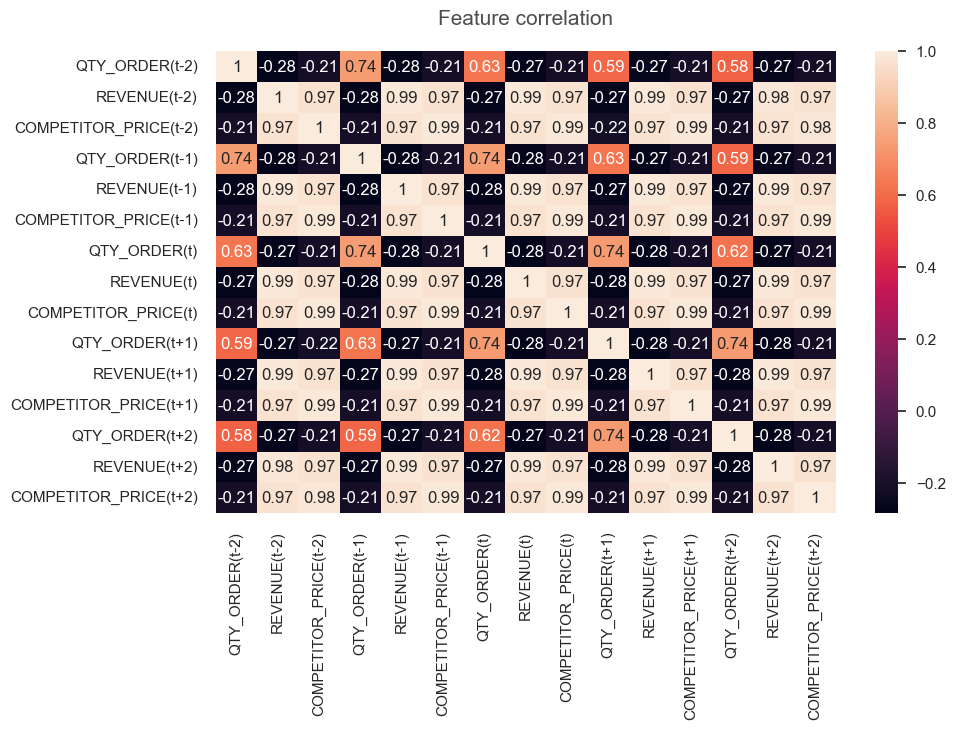

In [1061]:
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_transformed.corr(), ax=ax, annot=True)

ax.set_title("Feature correlation", fontsize=15, color='#4f4e4e', y=1.04)
# ax.bar_label(ax.containers[0], padding=2, fontsize=12, color='#4f4e4e')

plt.show()

There is a large relationship between the t* variables created previously. The features will be used in later analyses.

# Features and Training and Test split

In [1062]:
X = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"])
y = df_transformed["QTY_ORDER(t)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## Train and test by Produts

In [1063]:
base = 'PROD_ID'

X_trainp, X_testp, y_trainp, y_testp = [], [], [], []
prod_mapping = {}
c=0
for b in df[base].unique():
    Xp = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"]).loc[df_transformed[base] == b]
    yp = df_transformed["QTY_ORDER(t)"].loc[df_transformed[base] == b]
    
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xp, yp, test_size=.2)
    
    X_trainp.append(X_train_t)
    X_testp.append(X_test_t)
    y_trainp.append(y_train_t)
    y_testp.append(y_test_t)

    prod_mapping[c] = b
    c+=1

## K-means

In [1064]:
df_clust = df.groupby(['PROD_ID']).agg({'QTY_ORDER': ['sum'], 'REVENUE': ['sum']}).reset_index()
df_clust.columns = df_clust.columns.get_level_values(0)
df_clust_prodid = df_clust["PROD_ID"]
df_clust = df_clust.drop(columns=["PROD_ID"])

scaler = MinMaxScaler()
scaler.fit(df_clust)
scaled_df = scaler.transform(df_clust)
scaled_df = pd.DataFrame(scaled_df, columns=df_clust.columns)

df_clust

,QTY_ORDER,REVENUE
0,3597.143168,351287.831255
1,49132.265996,194956.364284
2,2470.633106,308111.805211
3,12431.904156,99455.123366
4,14940.066835,149408.145137
5,2723.437701,491197.768680
6,177069.942954,194498.385509
7,18049.193527,88309.741122
8,11923.209047,91042.659545


C:\Users\erycm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_clusters= 1, inertia=1.7692283947273122
n_clusters= 2, inertia=0.8870521511247611
n_clusters= 3, inertia=0.19866746544706415
n_clusters= 4, inertia=0.09154449853510149
n_clusters= 5, inertia=0.021688488900089196
n_clusters= 6, inertia=0.0069370791881581155
n_clusters= 7, inertia=0.0011739554682326015


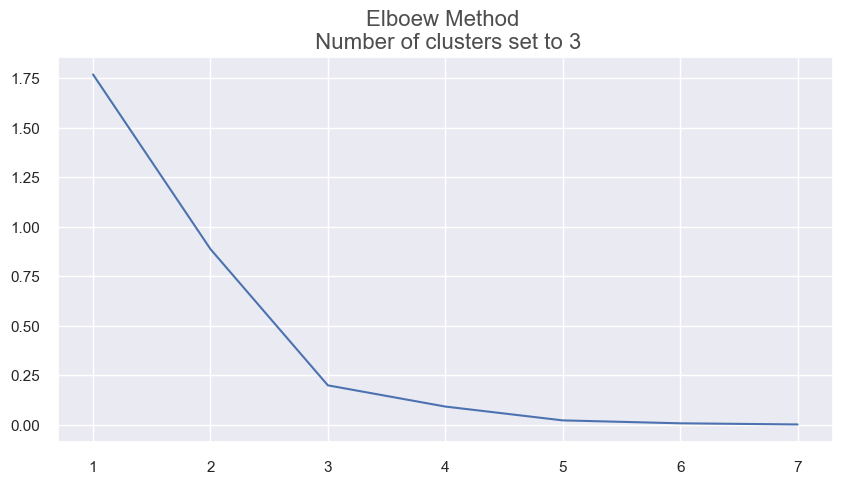

In [1065]:
inertias = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)
    print(f"n_clusters= {i}, inertia={kmeans.inertia_}")


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.lineplot(y=inertias, x=range(1,8), ax=axes)
axes.set_title("Elboew Method \n Number of clusters set to 3", fontsize=16, color='#4f4e4e')
plt.show()

In [1066]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)
cluster_label = kmeans.predict(scaled_df)
df_clust["LABEL"] = cluster_label
df_clust = pd.concat([df_clust_prodid, df_clust], axis=1)

label = [] 
for prod in df_transformed['PROD_ID'].values:
    label.append(int(df_clust['LABEL'].loc[df_clust['PROD_ID'] == prod].values[0]))
df_transformed['LABEL'] = label

df_clust

,PROD_ID,QTY_ORDER,REVENUE,LABEL
0,P1,3597.143168,351287.831255,0
1,P2,49132.265996,194956.364284,1
2,P3,2470.633106,308111.805211,0
3,P4,12431.904156,99455.123366,1
4,P5,14940.066835,149408.145137,1
5,P6,2723.437701,491197.768680,0
6,P7,177069.942954,194498.385509,2
7,P8,18049.193527,88309.741122,1
8,P9,11923.209047,91042.659545,1


In [1067]:
df_clust.groupby(["LABEL"]).count()

,PROD_ID,QTY_ORDER,REVENUE
LABEL,,,
0,3,3,3
1,5,5,5
2,1,1,1


In [1068]:
base = 'LABEL'

X_traincls, X_testcls, y_traincls, y_testcls = [], [], [], []
cluster_mapping = {}
c=0
for b in df_transformed[base].unique():
    Xcls = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID", 'LABEL']).loc[df_transformed[base] == b]
    ycls = df_transformed["QTY_ORDER(t)"].loc[df_transformed[base] == b]
    
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(Xcls, ycls, test_size=.2)

    X_traincls.append(X_train_cls)
    X_testcls.append(X_test_cls)
    y_traincls.append(y_train_cls)
    y_testcls.append(y_test_cls)

    cluster_mapping[c] = b
    c+=1

In [1069]:
df_transformed

,QTY_ORDER(t-2),REVENUE(t-2),COMPETITOR_PRICE(t-2),QTY_ORDER(t-1),REVENUE(t-1),COMPETITOR_PRICE(t-1),QTY_ORDER(t),REVENUE(t),COMPETITOR_PRICE(t),QTY_ORDER(t+1),REVENUE(t+1),COMPETITOR_PRICE(t+1),QTY_ORDER(t+2),REVENUE(t+2),COMPETITOR_PRICE(t+2),PROD_ID,LABEL
0,10.0,1499.00,1499.00,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.000000,1499.00,1499.00,P1,0
1,12.0,1349.10,1349.10,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.000000,1424.05,1424.05,P1,0
2,21.0,1349.10,1349.10,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.000000,1349.10,1349.10,P1,0
3,4.0,1499.00,1499.00,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.000000,1259.10,1259.10,P1,0
4,7.0,1499.00,1499.00,5.0,1424.05,1424.05,10.0,1349.10,1349.10,11.0,1259.10,1259.10,16.000000,1259.10,1259.10,P1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,50.0,359.10,414.00,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.000000,388.89,395.82,P9,1
2122,259.0,355.41,399.00,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.000000,388.66,395.82,P9,1
2123,370.0,355.41,399.95,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.000000,388.63,395.76,P9,1
2124,175.0,355.41,395.85,129.0,388.89,395.82,87.0,388.66,395.82,110.0,388.63,395.76,328.000000,341.10,393.00,P9,1


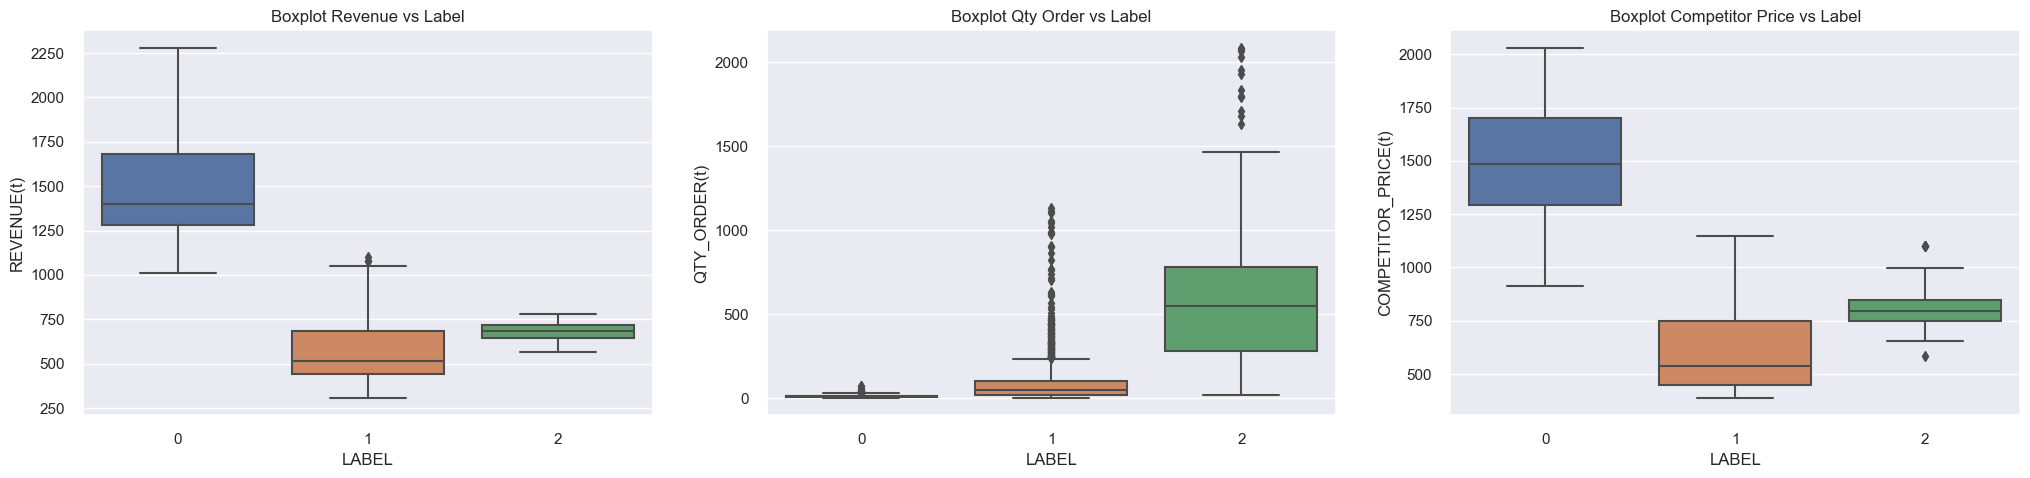

In [1070]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

sns.boxplot(data=df_transformed, x='LABEL', y='REVENUE(t)', ax=ax[0])
sns.boxplot(data=df_transformed, x='LABEL', y='QTY_ORDER(t)', ax=ax[1])
sns.boxplot(data=df_transformed, x='LABEL', y='COMPETITOR_PRICE(t)', ax=ax[2])

ax[0].set_title("Boxplot Revenue vs Label")
ax[1].set_title("Boxplot Qty Order vs Label")
ax[2].set_title("Boxplot Competitor Price vs Label")


plt.show()

# Model prediction

## Linear Regression

In [1089]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("r2 score train: ",r2_score(y_train, y_pred_train))
print("r2 score train: ",r2_score(y_test, y_pred))
print('MAPE: ',mean_absolute_percentage_error(y_test, y_pred))

r2 score train:  0.6851492858459431
r2 score train:  0.6523198740437764
MAPE:  1.4818959834005365


### Validation of Results

R2 Score Train:  0.6802536114552156
R2 Score Test:  0.6699377342618494
MAPE:  2.18715340771986


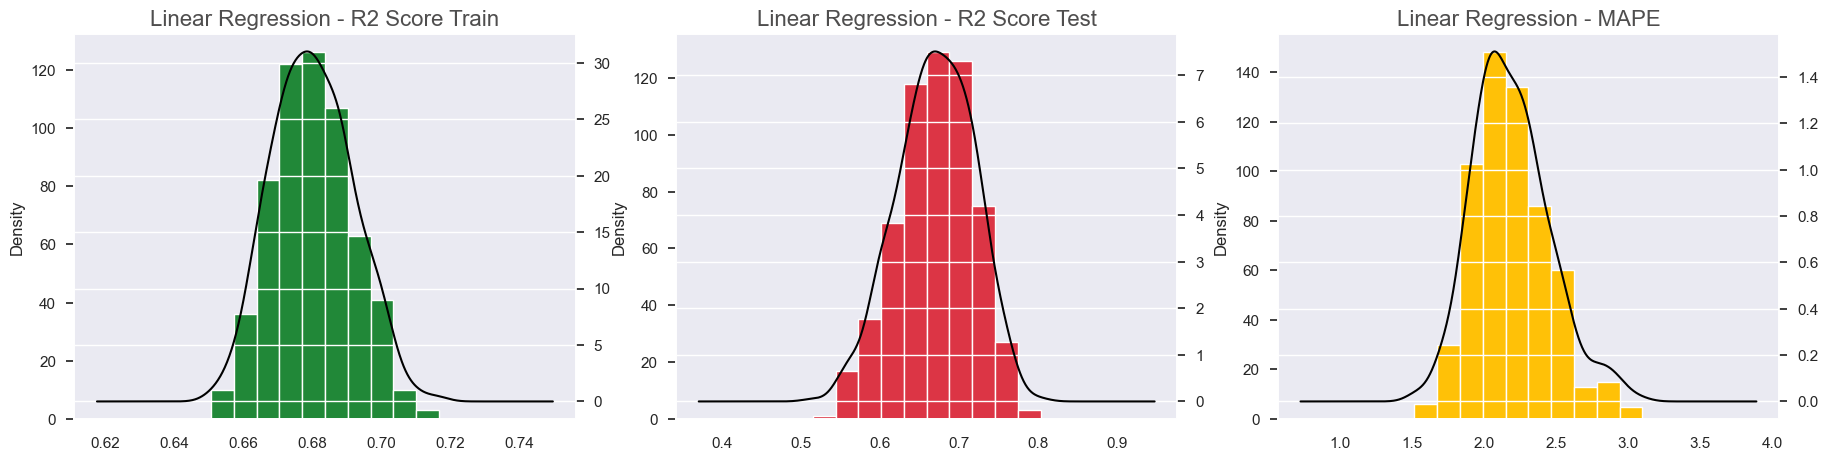

In [1135]:
lrr_model_report = pd.DataFrame()
predict_traning = []

for exec in range(600):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mdl = {'r2_score_train': r2_score(y_train, y_pred_train), 'r2_score_test': r2_score(y_test, y_pred), 'MAPE_test': mean_absolute_percentage_error(y_test, y_pred)}
    predict_traning.append(mdl)

lrr_model_report = pd.json_normalize(predict_traning)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,5))

axes[0].set_title("Linear Regression - R2 Score Train", fontsize=16, color='#4f4e4e')
lrr_model_report['r2_score_train'].plot.hist(ax=axes[0], color="#218838")
lrr_model_report['r2_score_train'].plot(kind='kde', ax=axes[0], secondary_y=True, color='black')

axes[1].set_title("Linear Regression - R2 Score Test", fontsize=16, color='#4f4e4e')
lrr_model_report['r2_score_test'].plot.hist(ax=axes[1], color="#dc3545")
lrr_model_report['r2_score_test'].plot(kind='kde', ax=axes[1], secondary_y=True, color='black')


axes[2].set_title("Linear Regression - MAPE", fontsize=16, color='#4f4e4e')
lrr_model_report['MAPE_test'].plot.hist(ax=axes[2], color="#ffc107")
lrr_model_report['MAPE_test'].plot(kind='kde', ax=axes[2], secondary_y=True, color='black')

print("R2 Score Train: ", lrr_model_report['r2_score_train'].mean())
print("R2 Score Test: ", lrr_model_report['r2_score_test'].mean())
print('MAPE: ',lrr_model_report['MAPE_test'].mean())
plt.show()

### Traning by Product

In [1104]:
for i in range(len(prod_mapping)):
    model = LinearRegression()
    model.fit(X_trainp[i], y_trainp[i])
    y_predp = model.predict(X_testp[i])
    y_pred_trainp = model.predict(X_trainp[i])
    print("R2 Score Train ",prod_mapping[i], ": ", r2_score(y_trainp[i], y_pred_trainp))
    print("R2 Score Test ",prod_mapping[i], ": ", r2_score(y_testp[i], y_predp))
    print('MAPE ', mean_absolute_percentage_error(y_testp[i], y_predp))
    print("--------------")

R2 Score Train  P1 :  0.47633538173105927
R2 Score Test  P1 :  0.24652445702218095
MAPE  0.4499425897616994
--------------
R2 Score Train  P2 :  0.6515821813288688
R2 Score Test  P2 :  0.1454384005490783
MAPE  0.9224708515459221
--------------
R2 Score Train  P3 :  0.4836329298782045
R2 Score Test  P3 :  0.563985971564991
MAPE  0.6877590551393551
--------------
R2 Score Train  P4 :  0.5839653645103546
R2 Score Test  P4 :  0.6607361903617579
MAPE  1.204890228596733
--------------
R2 Score Train  P5 :  0.6948327505468395
R2 Score Test  P5 :  0.40978879106219024
MAPE  5.162658455775535
--------------
R2 Score Train  P6 :  0.3556251225486754
R2 Score Test  P6 :  0.12850257239895346
MAPE  0.7401319365594358
--------------
R2 Score Train  P7 :  0.37771642768739233
R2 Score Test  P7 :  0.4307683499010111
MAPE  1.21542013668774
--------------
R2 Score Train  P8 :  0.5071018479539001
R2 Score Test  P8 :  0.5024186052062153
MAPE  0.9757523643474445
--------------
R2 Score Train  P9 :  0.52948252

### Linear Regression with K-means

In [1103]:
for i in range(len(cluster_mapping)):
    model = LinearRegression()
    model.fit(X_traincls[i], y_traincls[i])
    y_predcls = model.predict(X_testcls[i])
    y_pred_traincls = model.predict(X_traincls[i])
    print("R2 Score Train cluster ",cluster_mapping[i], ": ", r2_score(y_traincls[i], y_pred_traincls))
    print("R2 Score Test cluster ",cluster_mapping[i], ": ", r2_score(y_testcls[i], y_predcls))
    print('MAPE ', mean_absolute_percentage_error(y_testcls[i], y_predcls))
    print("--------------")

R2 Score Train cluster  0 :  0.41314888536731154
R2 Score Test cluster  0 :  0.5040454773732037
MAPE  0.6524803453879502
--------------
R2 Score Train cluster  1 :  0.55786615494564
R2 Score Test cluster  1 :  0.6254034600872409
MAPE  1.711243192830239
--------------
R2 Score Train cluster  2 :  0.37883736039789695
R2 Score Test cluster  2 :  0.461962224087321
MAPE  0.588304990033669
--------------


## XGBoost

In [1090]:
model = XGBRegressor(max_depth=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("r2 score train: ",r2_score(y_train, y_pred_train))
print("r2 score train: ",r2_score(y_test, y_pred))
print('MAPE: ',mean_absolute_percentage_error(y_test, y_pred))

r2 score train:  0.7575532393301815
r2 score train:  0.6631173360843476
MAPE:  1.0908073004870862


### Validation of Results

R2 Score Train:  0.6802536114552156
R2 Score Test:  0.6699377342618494
MAPE:  2.18715340771986


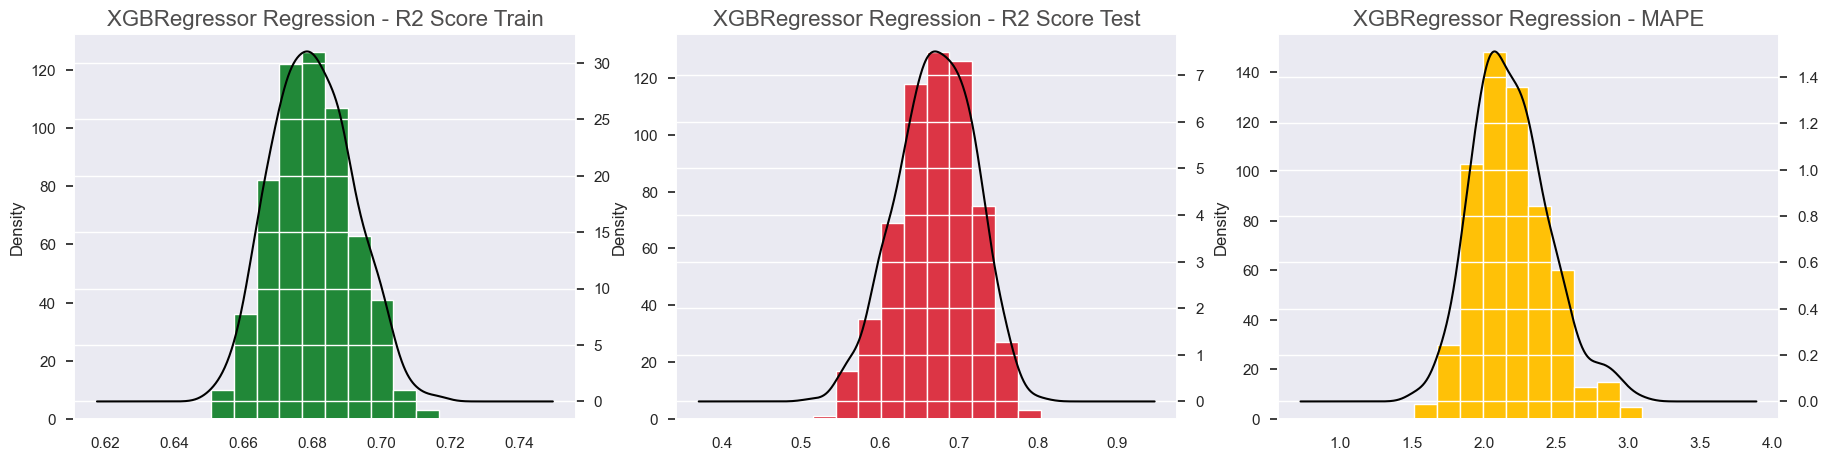

In [1134]:
xgbb_model_report = pd.DataFrame()
predict_traning = []

for exec in range(600):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    model = XGBRegressor(max_depth=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mdl = {'r2_score_train': r2_score(y_train, y_pred_train), 'r2_score_test': r2_score(y_test, y_pred), 'MAPE_test': mean_absolute_percentage_error(y_test, y_pred)}
    predict_traning.append(mdl)

xgbb_model_report = pd.json_normalize(predict_traning)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,5))

axes[0].set_title("XGBRegressor Regression - R2 Score Train", fontsize=16, color='#4f4e4e')
xgbb_model_report['r2_score_train'].plot.hist(ax=axes[0], color="#218838")
xgbb_model_report['r2_score_train'].plot(kind='kde', ax=axes[0], secondary_y=True, color='black')

axes[1].set_title("XGBRegressor Regression - R2 Score Test", fontsize=16, color='#4f4e4e')
xgbb_model_report['r2_score_test'].plot.hist(ax=axes[1], color="#dc3545")
xgbb_model_report['r2_score_test'].plot(kind='kde', ax=axes[1], secondary_y=True, color='black')


axes[2].set_title("XGBRegressor Regression - MAPE", fontsize=16, color='#4f4e4e')
xgbb_model_report['MAPE_test'].plot.hist(ax=axes[2], color="#ffc107")
xgbb_model_report['MAPE_test'].plot(kind='kde', ax=axes[2], secondary_y=True, color='black')

print("R2 Score Train: ", xgbb_model_report['r2_score_train'].mean())
print("R2 Score Test: ", xgbb_model_report['r2_score_test'].mean())
print('MAPE: ',xgbb_model_report['MAPE_test'].mean())
plt.show()

### Traning by Product

In [1101]:
for i in range(len(prod_mapping)):
    model = XGBRegressor(max_depth=1)
    model.fit(X_trainp[i], y_trainp[i])
    y_predp = model.predict(X_testp[i])
    y_pred_trainp = model.predict(X_trainp[i])
    print("R2 Score Train ",prod_mapping[i], ": ", r2_score(y_trainp[i], y_pred_trainp))
    print("R2 Score Test ",prod_mapping[i], ": ", r2_score(y_testp[i], y_predp))
    print('MAPE ', mean_absolute_percentage_error(y_testp[i], y_predp))
    print("--------------")

R2 Score Train  P1 :  0.6674814391349793
R2 Score Test  P1 :  0.2281960509298353
MAPE  0.5257231760127228
--------------
R2 Score Train  P2 :  0.8705675098667566
R2 Score Test  P2 :  0.015997030879995267
MAPE  0.816027642343214
--------------
R2 Score Train  P3 :  0.6728864323990628
R2 Score Test  P3 :  0.5043567152236232
MAPE  0.7907568819591078
--------------
R2 Score Train  P4 :  0.882741129026692
R2 Score Test  P4 :  0.44477910211883354
MAPE  1.251837159651567
--------------
R2 Score Train  P5 :  0.9287109203555347
R2 Score Test  P5 :  0.27090087137067165
MAPE  1.7215000915018734
--------------
R2 Score Train  P6 :  0.6196162905259024
R2 Score Test  P6 :  0.29455927415358685
MAPE  0.7259584695543375
--------------
R2 Score Train  P7 :  0.6004698933713147
R2 Score Test  P7 :  0.30088844907905554
MAPE  1.2505776724891846
--------------
R2 Score Train  P8 :  0.8232504059678374
R2 Score Test  P8 :  0.4272788798440257
MAPE  0.8003279686107077
--------------
R2 Score Train  P9 :  0.81715

### Xgboost with K-means

In [1102]:
for i in range(len(cluster_mapping)):
    model = XGBRegressor(max_depth=1)
    model.fit(X_traincls[i], y_traincls[i])
    y_predcls = model.predict(X_testcls[i])
    y_pred_traincls = model.predict(X_traincls[i])
    print("R2 Score Train cluster ",cluster_mapping[i], ": ", r2_score(y_traincls[i], y_pred_traincls))
    print("R2 Score Test cluster ",cluster_mapping[i], ": ", r2_score(y_testcls[i], y_predcls))
    print('MAPE ', mean_absolute_percentage_error(y_testcls[i], y_predcls))
    print("--------------")

R2 Score Train cluster  0 :  0.5276437386264878
R2 Score Test cluster  0 :  0.37649742910895423
MAPE  0.7413896701953767
--------------
R2 Score Train cluster  1 :  0.6769501362139347
R2 Score Test cluster  1 :  0.5395743721591384
MAPE  1.329113819721859
--------------
R2 Score Train cluster  2 :  0.5827238725710111
R2 Score Test cluster  2 :  0.48309729606077145
MAPE  0.5544782953739996
--------------


# Validation of Results by Product and Clusters

In [1110]:
lr_prod = []
lr_clus = []

xg_prod = []
xg_clus = []

for exec in range(600):
    base = 'LABEL'
    X_traincls, X_testcls, y_traincls, y_testcls = [], [], [], []
    cluster_mapping = {}
    c=0
    for b in df_transformed[base].unique():
        Xp = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID", 'LABEL']).loc[df_transformed[base] == b]
        yp = df_transformed["QTY_ORDER(t)"].loc[df_transformed[base] == b]
        
        X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(Xp, yp, test_size=.2)

        X_traincls.append(X_train_cls)
        X_testcls.append(X_test_cls)
        y_traincls.append(y_train_cls)
        y_testcls.append(y_test_cls)

        cluster_mapping[c] = b
        c+=1

    base = 'PROD_ID'
    X_trainp, X_testp, y_trainp, y_testp = [], [], [], []
    prod_mapping = {}
    c=0
    for b in df[base].unique():
        Xcls = df_transformed.drop(columns=["QTY_ORDER(t)", "PROD_ID"]).loc[df_transformed[base] == b]
        ycls = df_transformed["QTY_ORDER(t)"].loc[df_transformed[base] == b]
        
        X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(Xcls, ycls, test_size=.2)
        
        X_trainp.append(X_train_t)
        X_testp.append(X_test_t)
        y_trainp.append(y_train_t)
        y_testp.append(y_test_t)

        prod_mapping[c] = b
        c+=1


    for i in range(len(prod_mapping)):
        model = LinearRegression()
        model.fit(X_trainp[i], y_trainp[i])
        y_predp = model.predict(X_testp[i])
        y_pred_trainp = model.predict(X_trainp[i])

        mdl = {'r2_score_train_'+str(prod_mapping[i]): r2_score(y_trainp[i], y_pred_trainp),
            'r2_score_test_'+str(prod_mapping[i]): r2_score(y_testp[i], y_predp), 'MAPE_test_'+str(prod_mapping[i]): mean_absolute_percentage_error(y_testp[i], y_predp)}
        lr_prod.append(mdl)

    for i in range(len(cluster_mapping)):
        model = LinearRegression()
        model.fit(X_traincls[i], y_traincls[i])
        y_predcls = model.predict(X_testcls[i])
        y_pred_traincls = model.predict(X_traincls[i])

        mdl = {'r2_score_train_'+str(cluster_mapping[i]): r2_score(y_traincls[i], y_pred_traincls), 
            'r2_score_test_'+str(cluster_mapping[i]): r2_score(y_testcls[i], y_predcls), 'MAPE_test_'+str(cluster_mapping[i]): mean_absolute_percentage_error(y_testcls[i], y_predcls)}
        lr_clus.append(mdl)


    for i in range(len(prod_mapping)):
        model = XGBRegressor(max_depth=1)
        model.fit(X_trainp[i], y_trainp[i])
        y_predp = model.predict(X_testp[i])
        y_pred_trainp = model.predict(X_trainp[i])

        mdl = {'r2_score_train_'+str(prod_mapping[i]): r2_score(y_trainp[i], y_pred_trainp),
            'r2_score_test_'+str(prod_mapping[i]): r2_score(y_testp[i], y_predp), 'MAPE_test_'+str(prod_mapping[i]): mean_absolute_percentage_error(y_testp[i], y_predp)}
        xg_prod.append(mdl)

    for i in range(len(cluster_mapping)):
        model = XGBRegressor(max_depth=1)
        model.fit(X_traincls[i], y_traincls[i])
        y_predcls = model.predict(X_testcls[i])
        y_pred_traincls = model.predict(X_traincls[i])

        mdl = {'r2_score_train_'+str(cluster_mapping[i]): r2_score(y_traincls[i], y_pred_traincls), 
            'r2_score_test_'+str(cluster_mapping[i]): r2_score(y_testcls[i], y_predcls), 'MAPE_test_'+str(cluster_mapping[i]): mean_absolute_percentage_error(y_testcls[i], y_predcls)}
        xg_clus.append(mdl)

In [1111]:
lr_prod_model_report = pd.json_normalize(lr_prod)
lr_clus_model_report = pd.json_normalize(lr_clus)
xg_prod_model_report = pd.json_normalize(xg_prod)
xg_clus_model_report = pd.json_normalize(xg_clus)

lr_prod_model_report.to_csv('test_prc/lr_prod_model_report.csv', index=False)
lr_clus_model_report.to_csv('test_prc/lr_clus_model_report.csv', index=False)
xg_prod_model_report.to_csv('test_prc/xg_prod_model_report.csv', index=False)
xg_clus_model_report.to_csv('test_prc/xg_clus_model_report.csv', index=False)

lr_prod_model_report= pd.read_csv('test_prc/lr_prod_model_report.csv')
lr_clus_model_report= pd.read_csv('test_prc/lr_clus_model_report.csv')
xg_prod_model_report= pd.read_csv('test_prc/xg_prod_model_report.csv')
xg_clus_model_report= pd.read_csv('test_prc/xg_clus_model_report.csv')


In [1113]:
lr_prod_model_report

,r2_score_train_P1,r2_score_test_P1,MAPE_test_P1,r2_score_train_P2,r2_score_test_P2,MAPE_test_P2,r2_score_train_P3,r2_score_test_P3,MAPE_test_P3,r2_score_train_P4,...,MAPE_test_P6,r2_score_train_P7,r2_score_test_P7,MAPE_test_P7,r2_score_train_P8,r2_score_test_P8,MAPE_test_P8,r2_score_train_P9,r2_score_test_P9,MAPE_test_P9
0,0.459815,0.321107,0.628562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.579086,0.527837,1.312289,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.516069,0.347006,0.919944,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.62404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.121175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.427299,0.217192,0.88956,NaN,NaN,NaN,NaN,NaN,NaN
5398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.513316,0.532534,1.286046,NaN,NaN,NaN


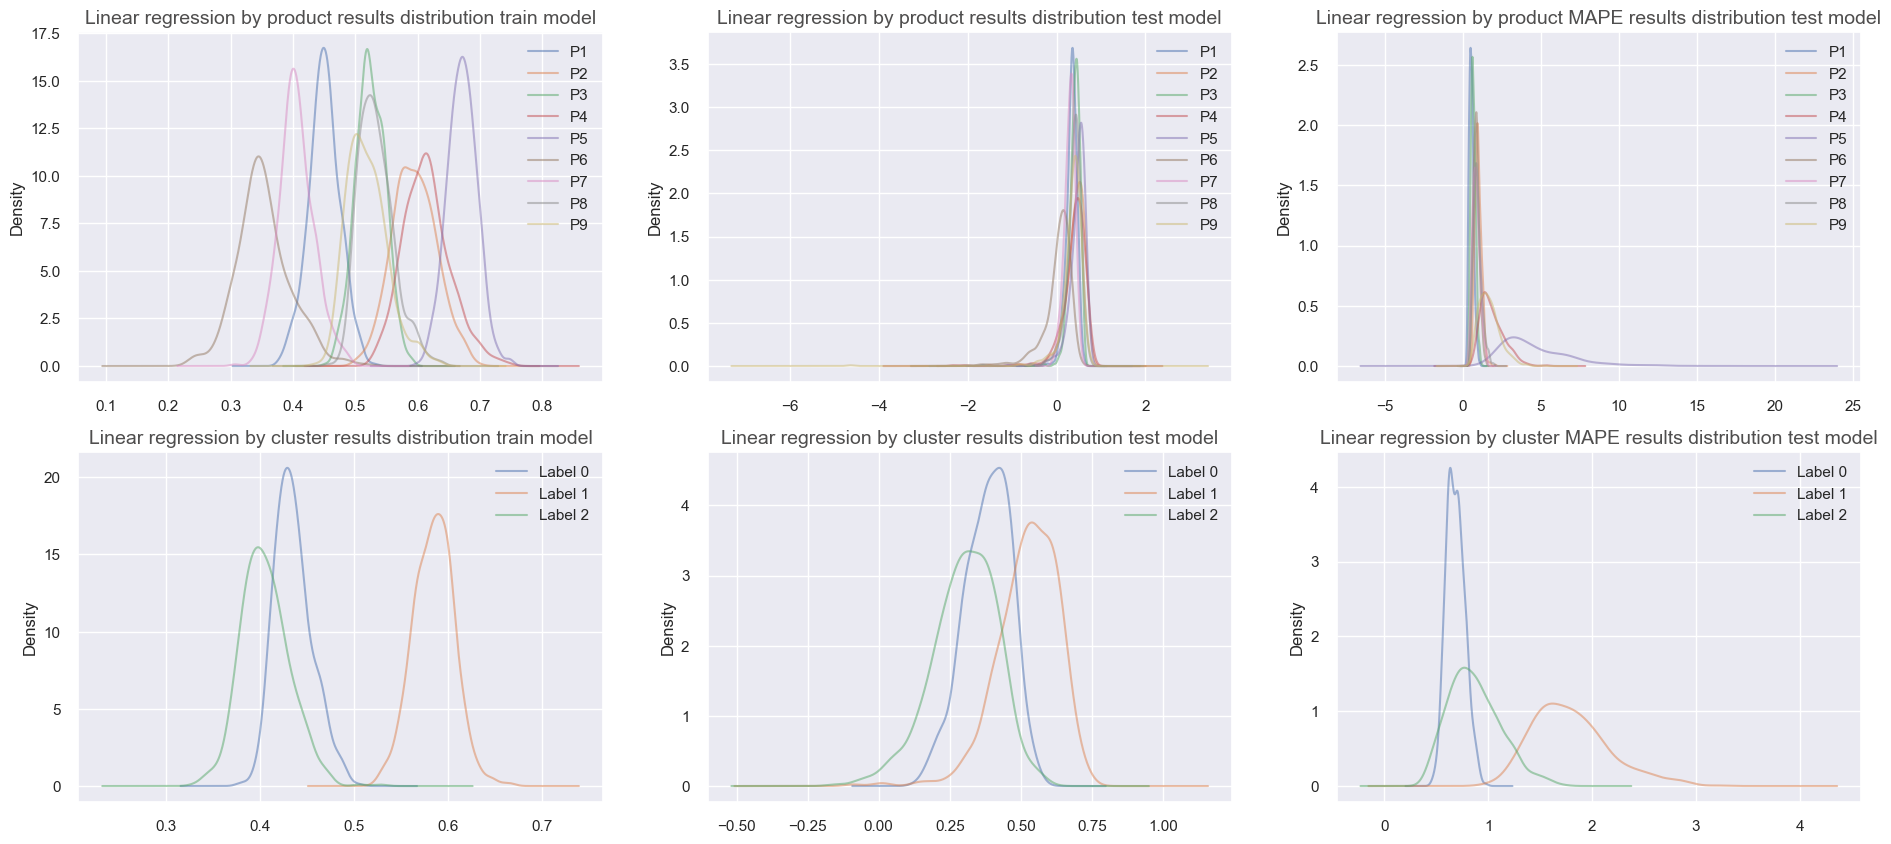

In [1124]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(23,10))

lr_prod_md_report = pd.DataFrame({
    'P1': lr_prod_model_report['r2_score_train_P1'].dropna(),
    'P2': lr_prod_model_report['r2_score_train_P2'].dropna(),
    'P3': lr_prod_model_report['r2_score_train_P3'].dropna(),
    'P4': lr_prod_model_report['r2_score_train_P4'].dropna(),
    'P5': lr_prod_model_report['r2_score_train_P5'].dropna(),
    'P6': lr_prod_model_report['r2_score_train_P6'].dropna(),
    'P7': lr_prod_model_report['r2_score_train_P7'].dropna(),
    'P8': lr_prod_model_report['r2_score_train_P8'].dropna(),
    'P9': lr_prod_model_report['r2_score_train_P9'].dropna(),
})

lr_prod_md_report.plot.kde(ax=axes[0][0], alpha=0.5)

axes[0][0].set_title("Linear regression by product results distribution train model", fontsize=14, color='#4f4e4e')

lr_prod_md_report = pd.DataFrame({
    'P1': lr_prod_model_report['r2_score_test_P1'].dropna(),
    'P2': lr_prod_model_report['r2_score_test_P2'].dropna(),
    'P3': lr_prod_model_report['r2_score_test_P3'].dropna(),
    'P4': lr_prod_model_report['r2_score_test_P4'].dropna(),
    'P5': lr_prod_model_report['r2_score_test_P5'].dropna(),
    'P6': lr_prod_model_report['r2_score_test_P6'].dropna(),
    'P7': lr_prod_model_report['r2_score_test_P7'].dropna(),
    'P8': lr_prod_model_report['r2_score_test_P8'].dropna(),
    'P9': lr_prod_model_report['r2_score_test_P9'].dropna(),
})

lr_prod_md_report.plot.kde(ax=axes[0][1], alpha=0.5)

axes[0][2].set_title("Linear regression by product MAPE results distribution test model", fontsize=14, color='#4f4e4e')

lr_prod_md_report = pd.DataFrame({
    'P1': lr_prod_model_report['MAPE_test_P1'].dropna(),
    'P2': lr_prod_model_report['MAPE_test_P2'].dropna(),
    'P3': lr_prod_model_report['MAPE_test_P3'].dropna(),
    'P4': lr_prod_model_report['MAPE_test_P4'].dropna(),
    'P5': lr_prod_model_report['MAPE_test_P5'].dropna(),
    'P6': lr_prod_model_report['MAPE_test_P6'].dropna(),
    'P7': lr_prod_model_report['MAPE_test_P7'].dropna(),
    'P8': lr_prod_model_report['MAPE_test_P8'].dropna(),
    'P9': lr_prod_model_report['MAPE_test_P9'].dropna(),
})

lr_prod_md_report.plot.kde(ax=axes[0][2], alpha=0.5)

axes[0][1].set_title("Linear regression by product results distribution test model", fontsize=14, color='#4f4e4e')

lr_clus_md_report = pd.DataFrame({
    'Label 0': lr_clus_model_report['r2_score_train_0'].dropna(),
    'Label 1': lr_clus_model_report['r2_score_train_1'].dropna(),
    'Label 2': lr_clus_model_report['r2_score_train_2'].dropna(),
})

lr_clus_md_report.plot.kde(ax=axes[1][0], alpha=0.5)

axes[1][0].set_title("Linear regression by cluster results distribution train model", fontsize=14, color='#4f4e4e')

lr_clus_md_report = pd.DataFrame({
    'Label 0': lr_clus_model_report['r2_score_test_0'].dropna(),
    'Label 1': lr_clus_model_report['r2_score_test_1'].dropna(),
    'Label 2': lr_clus_model_report['r2_score_test_2'].dropna(),

})

lr_clus_md_report.plot.kde(ax=axes[1][1], alpha=0.5)

axes[1][1].set_title("Linear regression by cluster results distribution test model", fontsize=14, color='#4f4e4e')

lr_clus_md_report = pd.DataFrame({
    'Label 0': lr_clus_model_report['MAPE_test_0'].dropna(),
    'Label 1': lr_clus_model_report['MAPE_test_1'].dropna(),
    'Label 2': lr_clus_model_report['MAPE_test_2'].dropna(),

})

lr_clus_md_report.plot.kde(ax=axes[1][2], alpha=0.5)

axes[1][2].set_title("Linear regression by cluster MAPE results distribution test model", fontsize=14, color='#4f4e4e')


plt.show()

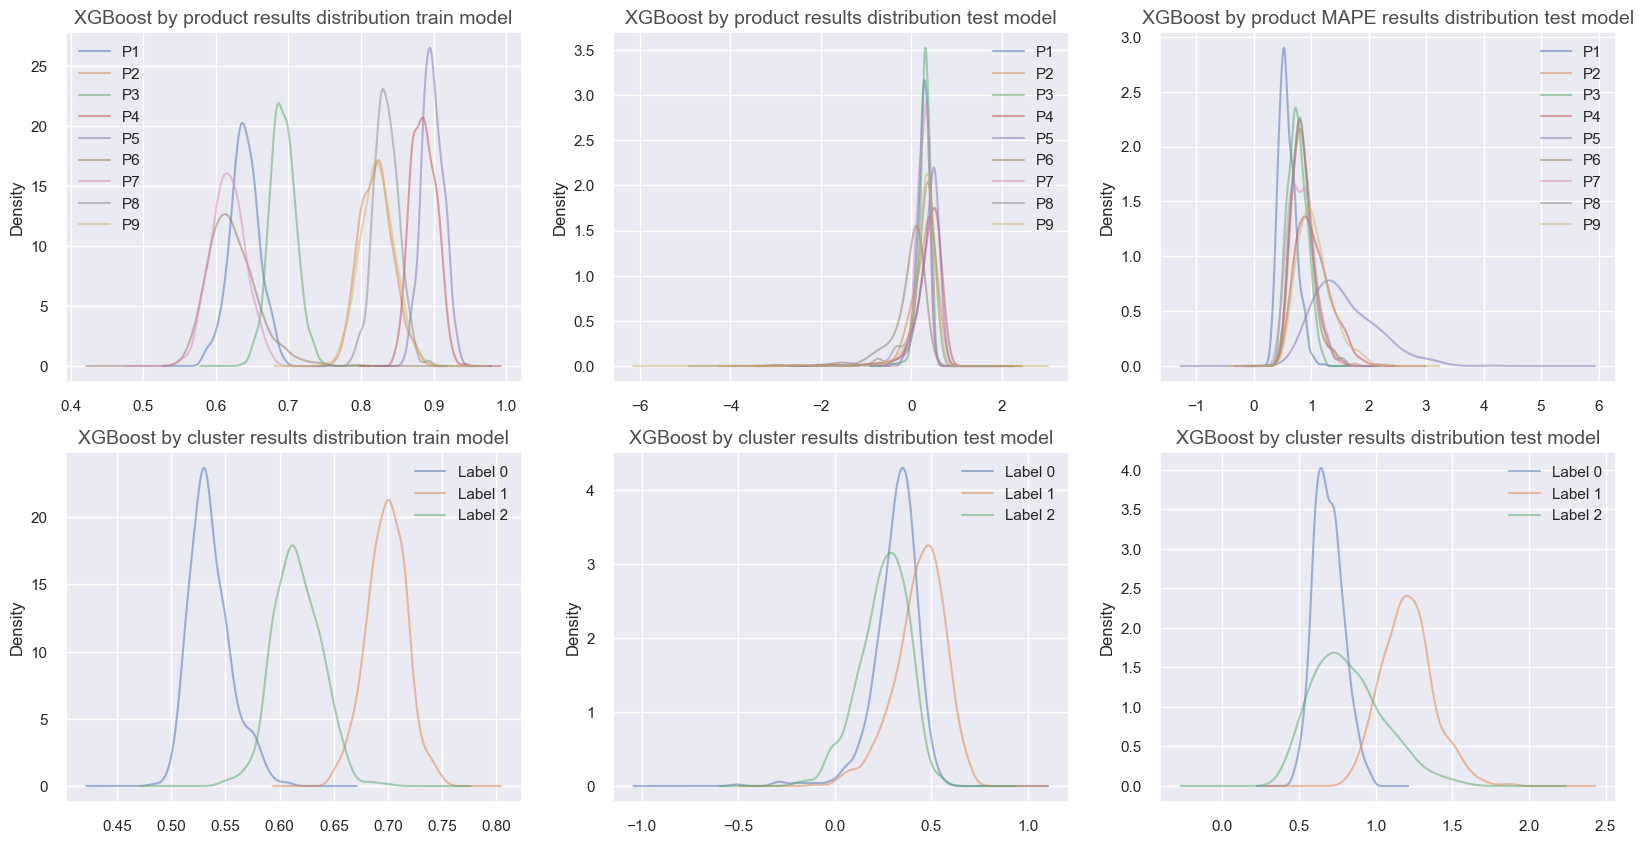

In [1138]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

xg_prod_md_report = pd.DataFrame({
    'P1': xg_prod_model_report['r2_score_train_P1'].dropna(),
    'P2': xg_prod_model_report['r2_score_train_P2'].dropna(),
    'P3': xg_prod_model_report['r2_score_train_P3'].dropna(),
    'P4': xg_prod_model_report['r2_score_train_P4'].dropna(),
    'P5': xg_prod_model_report['r2_score_train_P5'].dropna(),
    'P6': xg_prod_model_report['r2_score_train_P6'].dropna(),
    'P7': xg_prod_model_report['r2_score_train_P7'].dropna(),
    'P8': xg_prod_model_report['r2_score_train_P8'].dropna(),
    'P9': xg_prod_model_report['r2_score_train_P9'].dropna(),
})

xg_prod_md_report.plot.kde(ax=axes[0][0], alpha=0.5)

axes[0][0].set_title("XGBoost by product results distribution train model", fontsize=14, color='#4f4e4e')

xg_prod_md_report = pd.DataFrame({
    'P1': xg_prod_model_report['r2_score_test_P1'].dropna(),
    'P2': xg_prod_model_report['r2_score_test_P2'].dropna(),
    'P3': xg_prod_model_report['r2_score_test_P3'].dropna(),
    'P4': xg_prod_model_report['r2_score_test_P4'].dropna(),
    'P5': xg_prod_model_report['r2_score_test_P5'].dropna(),
    'P6': xg_prod_model_report['r2_score_test_P6'].dropna(),
    'P7': xg_prod_model_report['r2_score_test_P7'].dropna(),
    'P8': xg_prod_model_report['r2_score_test_P8'].dropna(),
    'P9': xg_prod_model_report['r2_score_test_P9'].dropna(),
})

xg_prod_md_report.plot.kde(ax=axes[0][1], alpha=0.5)

axes[0][1].set_title("XGBoost by product results distribution test model", fontsize=14, color='#4f4e4e')


axes[0][2].set_title("XGBoost by product MAPE results distribution test model", fontsize=14, color='#4f4e4e')

xg_prod_md_report = pd.DataFrame({
    'P1': xg_prod_model_report['MAPE_test_P1'].dropna(),
    'P2': xg_prod_model_report['MAPE_test_P2'].dropna(),
    'P3': xg_prod_model_report['MAPE_test_P3'].dropna(),
    'P4': xg_prod_model_report['MAPE_test_P4'].dropna(),
    'P5': xg_prod_model_report['MAPE_test_P5'].dropna(),
    'P6': xg_prod_model_report['MAPE_test_P6'].dropna(),
    'P7': xg_prod_model_report['MAPE_test_P7'].dropna(),
    'P8': xg_prod_model_report['MAPE_test_P8'].dropna(),
    'P9': xg_prod_model_report['MAPE_test_P9'].dropna(),
})

xg_prod_md_report.plot.kde(ax=axes[0][2], alpha=0.5)


xg_clus_md_report = pd.DataFrame({
    'Label 0': xg_clus_model_report['r2_score_train_0'].dropna(),
    'Label 1': xg_clus_model_report['r2_score_train_1'].dropna(),
    'Label 2': xg_clus_model_report['r2_score_train_2'].dropna(),
})

xg_clus_md_report.plot.kde(ax=axes[1][0], alpha=0.5)

axes[1][0].set_title("XGBoost by cluster results distribution train model", fontsize=14, color='#4f4e4e')

xg_clus_md_report = pd.DataFrame({
    'Label 0': xg_clus_model_report['r2_score_test_0'].dropna(),
    'Label 1': xg_clus_model_report['r2_score_test_1'].dropna(),
    'Label 2': xg_clus_model_report['r2_score_test_2'].dropna(),

})

xg_clus_md_report.plot.kde(ax=axes[1][1], alpha=0.5)

axes[1][1].set_title("XGBoost by cluster results distribution test model", fontsize=14, color='#4f4e4e')

xg_clus_md_report = pd.DataFrame({
    'Label 0': xg_clus_model_report['MAPE_test_0'].dropna(),
    'Label 1': xg_clus_model_report['MAPE_test_1'].dropna(),
    'Label 2': xg_clus_model_report['MAPE_test_2'].dropna(),

})

xg_clus_md_report.plot.kde(ax=axes[1][2], alpha=0.5)

axes[1][2].set_title("XGBoost by cluster results distribution test model", fontsize=14, color='#4f4e4e')

plt.show()

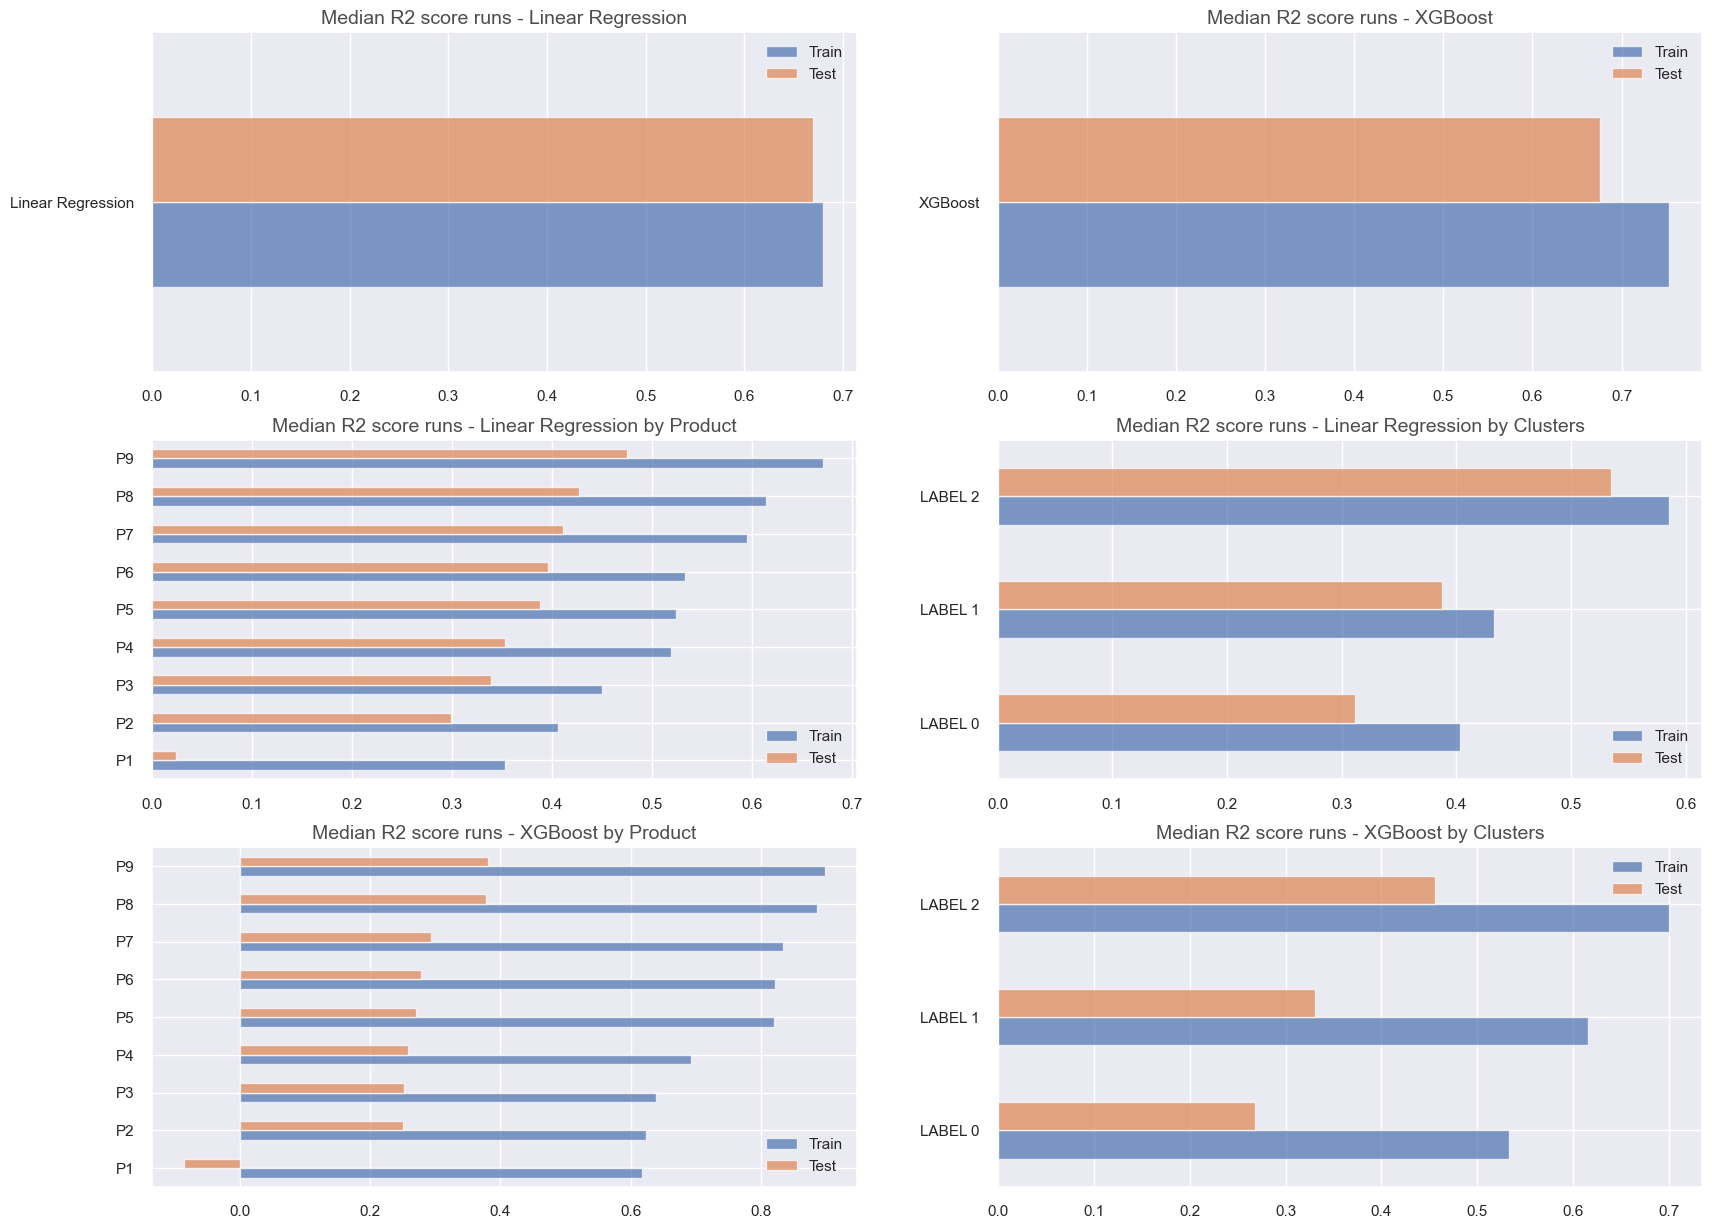

In [1131]:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))

axes[0][0].set_title("Median R2 score runs - Linear Regression", fontsize=14, color='#4f4e4e')
reportpr = pd.DataFrame({'Train': lrr_model_report['r2_score_train'].mean(),
                       'Test': lrr_model_report['r2_score_test'].mean()}, index=['Linear Regression'])
reportpr.plot.barh(alpha=0.7, ax=axes[0][0])

axes[0][1].set_title("Median R2 score runs - XGBoost", fontsize=14, color='#4f4e4e')
reportpr = pd.DataFrame({'Train': xgbb_model_report['r2_score_train'].mean(),
                       'Test': xgbb_model_report['r2_score_test'].mean()}, index=['XGBoost'])
reportpr.plot.barh(alpha=0.7, ax=axes[0][1])

axes[1][0].set_title("Median R2 score runs - Linear Regression by Product", fontsize=14, color='#4f4e4e')
reportpr = pd.DataFrame({'Train': lr_prod_model_report[['r2_score_train_P1', 'r2_score_train_P2', 'r2_score_train_P3', 'r2_score_train_P4', 'r2_score_train_P5', 'r2_score_train_P6', 'r2_score_train_P7', 'r2_score_train_P8', 'r2_score_train_P9']].mean().sort_values().values,
                   'Test': lr_prod_model_report[['r2_score_test_P1', 'r2_score_test_P2', 'r2_score_test_P3', 'r2_score_test_P4', 'r2_score_test_P5', 'r2_score_test_P6', 'r2_score_test_P7', 'r2_score_test_P8', 'r2_score_test_P9']].mean().sort_values().values}, index=['P1','P2','P3','P4','P5','P6','P7','P8','P9'])
reportpr.plot.barh(alpha=0.7, ax=axes[1][0])

axes[1][1].set_title("Median R2 score runs - Linear Regression by Clusters", fontsize=14, color='#4f4e4e')
reportcr = pd.DataFrame({'Train': lr_clus_model_report[['r2_score_train_0', 'r2_score_train_1', 'r2_score_train_2']].median().sort_values().values,
                   'Test': lr_clus_model_report[['r2_score_test_0', 'r2_score_test_1', 'r2_score_test_2']].median().sort_values().values}, index=['LABEL 0','LABEL 1','LABEL 2'])
reportcr.plot.barh(alpha=0.7, ax=axes[1][1])

axes[2][0].set_title("Median R2 score runs - XGBoost by Product", fontsize=14, color='#4f4e4e')
reportpx = pd.DataFrame({'Train': xg_prod_model_report[['r2_score_train_P1', 'r2_score_train_P2', 'r2_score_train_P3', 'r2_score_train_P4', 'r2_score_train_P5', 'r2_score_train_P6', 'r2_score_train_P7', 'r2_score_train_P8', 'r2_score_train_P9']].mean().sort_values().values,
                   'Test': xg_prod_model_report[['r2_score_test_P1', 'r2_score_test_P2', 'r2_score_test_P3', 'r2_score_test_P4', 'r2_score_test_P5', 'r2_score_test_P6', 'r2_score_test_P7', 'r2_score_test_P8', 'r2_score_test_P9']].mean().sort_values().values}, index=['P1','P2','P3','P4','P5','P6','P7','P8','P9'])
reportpx.plot.barh(alpha=0.7, ax=axes[2][0])

axes[2][1].set_title("Median R2 score runs - XGBoost by Clusters", fontsize=14, color='#4f4e4e')
reportcx = pd.DataFrame({'Train': xg_clus_model_report[['r2_score_train_0', 'r2_score_train_1', 'r2_score_train_2']].median().sort_values().values,
                   'Test': xg_clus_model_report[['r2_score_test_0', 'r2_score_test_1', 'r2_score_test_2']].median().sort_values().values}, index=['LABEL 0','LABEL 1','LABEL 2'])
reportcx.plot.barh(alpha=0.7, ax=axes[2][1])

plt.show()


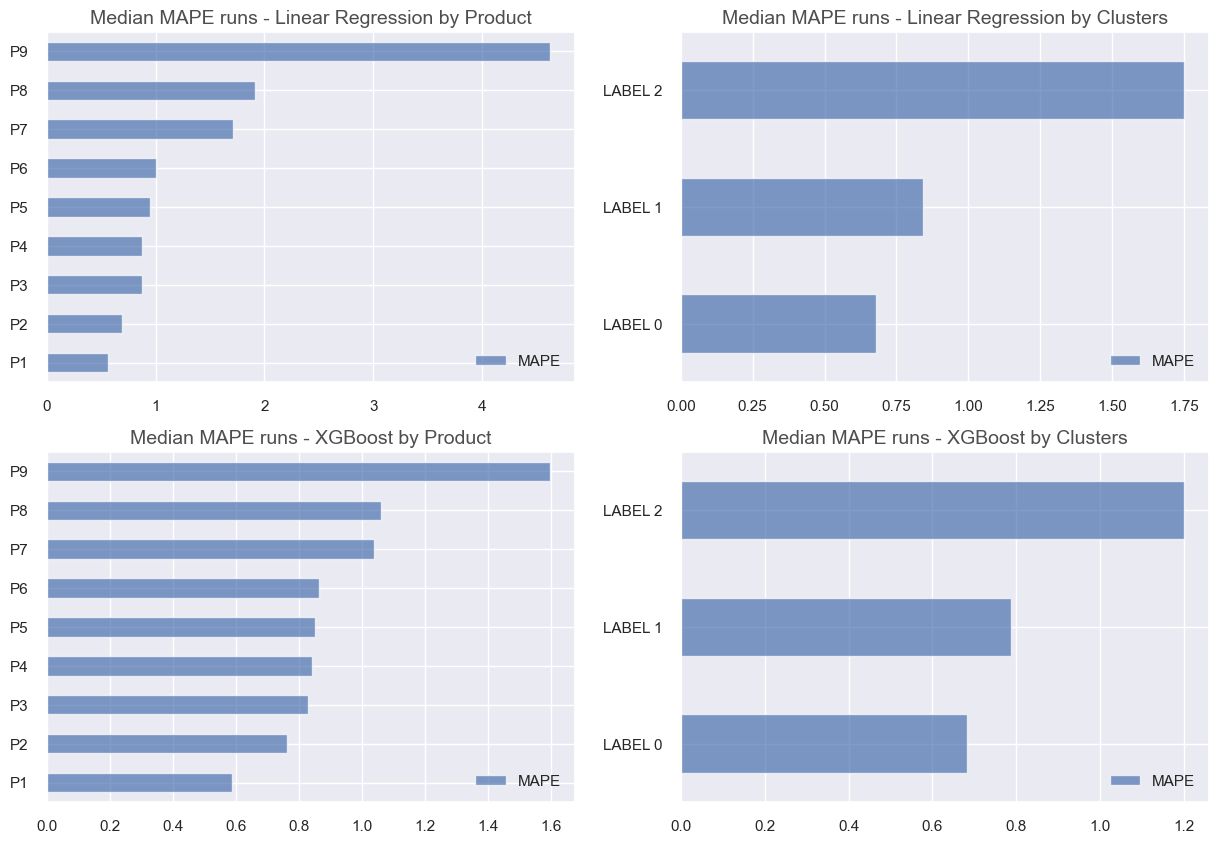

In [1145]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axes[0][0].set_title("Median MAPE runs - Linear Regression by Product", fontsize=14, color='#4f4e4e')
reportpr = pd.DataFrame({'MAPE': lr_prod_model_report[['MAPE_test_P1', 'MAPE_test_P2', 'MAPE_test_P3', 'MAPE_test_P4', 'MAPE_test_P5', 'MAPE_test_P6', 'MAPE_test_P7', 'MAPE_test_P8', 'MAPE_test_P9']].mean().sort_values().values}, index=['P1','P2','P3','P4','P5','P6','P7','P8','P9'])
reportpr.plot.barh(alpha=0.7, ax=axes[0][0])

axes[0][1].set_title("Median MAPE runs - Linear Regression by Clusters", fontsize=14, color='#4f4e4e')
reportcr = pd.DataFrame({'MAPE': lr_clus_model_report[['MAPE_test_0', 'MAPE_test_1', 'MAPE_test_2']].median().sort_values().values}, index=['LABEL 0','LABEL 1','LABEL 2'])
reportcr.plot.barh(alpha=0.7, ax=axes[0][1])

axes[1][0].set_title("Median MAPE runs - XGBoost by Product", fontsize=14, color='#4f4e4e')
reportpx = pd.DataFrame({'MAPE': xg_prod_model_report[['MAPE_test_P1', 'MAPE_test_P2', 'MAPE_test_P3', 'MAPE_test_P4', 'MAPE_test_P5', 'MAPE_test_P6', 'MAPE_test_P7', 'MAPE_test_P8', 'MAPE_test_P9']].mean().sort_values().values}, index=['P1','P2','P3','P4','P5','P6','P7','P8','P9'])
reportpx.plot.barh(alpha=0.7, ax=axes[1][0])

axes[1][1].set_title("Median MAPE runs - XGBoost by Clusters", fontsize=14, color='#4f4e4e')
reportcx = pd.DataFrame({'MAPE': xg_clus_model_report[['MAPE_test_0', 'MAPE_test_1', 'MAPE_test_2']].median().sort_values().values}, index=['LABEL 0','LABEL 1','LABEL 2'])
reportcx.plot.barh(alpha=0.7, ax=axes[1][1])

plt.show()

# Results and Next Steps

Despite the significant relevance of the results in the execution of the models with all data available in R2 score, there is a problem in the prediction by products analyzed in the MAPE method. MAPE was used in this experiment in order to avoid biases with values above the expected, thus avoiding possible overbought problems.
Both algorithms presented greater prediction difficulties for the products P1, P2 and P3, even resulting in a negative R2 for P1 (worse than a horizontal line). Clustering in turn alleviated discrepancies in results when compared to one-to-one products.
As next steps, I would choose to follow the processing with clustering, exploring new parameterizations for the existing algorithms and relating the features with possible new information.